In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [6]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [7]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [8]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [9]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [10]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [11]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [12]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [13]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [14]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [15]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [16]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [17]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [18]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter_no_change = 3, loss = 'squared_loss', penalty = 'l2')

In [19]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [20]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000116DAAE50D0>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000116DAAE5670>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000116DAA

In [21]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

124.67230746253693

### Подбор параметров

In [22]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__verbose'

In [23]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [24]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [25]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 2.46 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x00000116DAAE50D0>)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000116DAAE5670>)),
                                                                                        ('scaling',
                                                                                         StandardScaler(wit...
                                                                       ('categorical_variables_pro

In [26]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-117.0109326227479
{'model_fitting__alpha': 0.0001, 'model_fitting__eta0': 0.001}


### Оценка по отложенному тесту

In [27]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [28]:
metrics.mean_absolute_error(test_labels, test_predictions)

122.16931018853086

In [29]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [30]:
print(test_predictions[:20])

[149.23719513 171.2202063  213.80363775 242.97152604 259.91717222
 275.51133663 278.2370173  303.82165844 309.32308628 319.3865105
 317.02986401 310.43225911 294.27905601 280.65488939 272.33588267
 244.72147288 249.63132026  63.00985815  70.3815233   77.75318844]


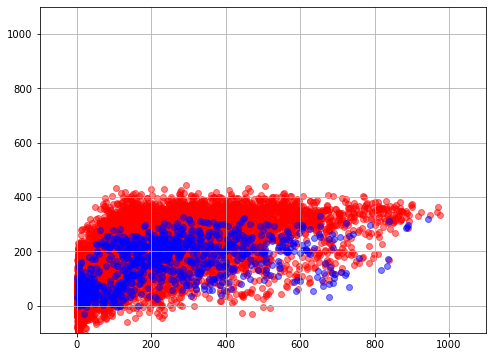

In [31]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [34]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [35]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000116DB162940>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000116DB1629D0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0,
                                                                                 with_std=1))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                 

In [36]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.49758619912876

In [37]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [38]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

Text(0.5, 1.0, 'random forest model')

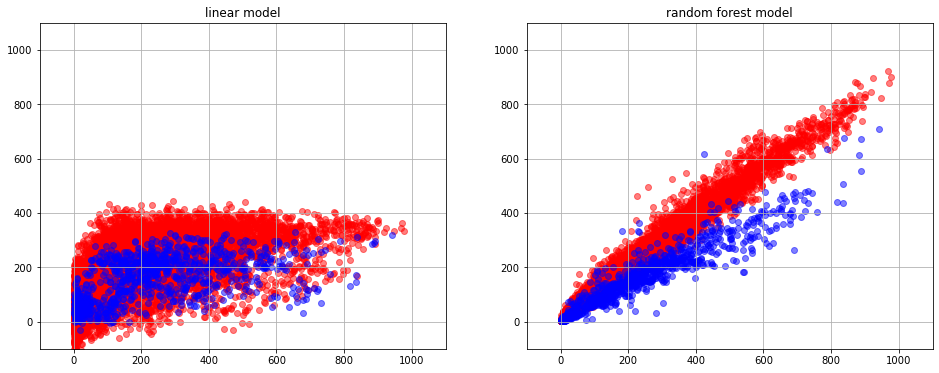

In [39]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')